In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

%matplotlib inline

BS_TEST = 32
BS_TRAIN = 32


In [43]:
torch.__version__

'1.3.1'

In [2]:
transform_ds = transforms.Compose([transforms.ToTensor()])

train_ds = datasets.MNIST(root="data", train=True, download=True, transform=transform_ds)
test_ds = datasets.MNIST(root="data", train=False, download=True, transform=transform_ds)


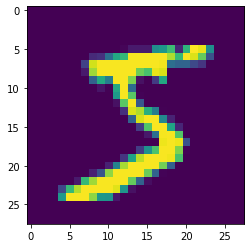

In [29]:
plt.imshow(train_ds.train_data[0].numpy())

In [3]:
train_loader = DataLoader(train_ds, batch_size=BS_TRAIN, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BS_TEST, shuffle=True)


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [6]:
class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size):
        super(RNNClassifier, self).__init__()
        
        self.input_size = input_size
        self.hidden_dim = hidden_dim
        self.output_size = output_size
        
        self.lstm = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_dim,
                            num_layers=1, batch_first=True)
        self.fc = nn.Linear(self.hidden_dim, self.output_size)
    
    def forward(self, x):
        x = x.view(-1, 28, 28)
        x, hidden = self.lstm(x)
        x = self.fc(x[:, -1, :])
        return x

model = RNNClassifier(input_size=28, hidden_dim=64, output_size=10)
print(model)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
        

RNNClassifier(
  (lstm): LSTM(28, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=10, bias=True)
)


In [8]:
EPOCHS = 25

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    train_accuracy = 0
    for samples, labels in train_loader:
        samples, labels = samples.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model.forward(samples)
        loss = criterion(output, labels)
        train_loss += loss.item() * len(samples)
        train_accuracy += sum(torch.max(output, dim=1)[1] == labels).item()
        loss.backward()
        optimizer.step()
    else:
        train_loss /= len(train_ds) 
        train_accuracy /= len(train_ds)
    
    model.eval()
    test_loss = 0
    test_accuracy = 0
    with torch.no_grad():
        for samples, labels in test_loader:
            samples, labels = samples.to(device), labels.to(device)
            output = model.forward(samples)
            loss = criterion(output, labels)
            test_loss += loss.item() * len(samples)
            test_accuracy += sum(torch.max(output, dim=1)[1] == labels).item()
        else:
            test_loss /= len(test_ds) 
            test_accuracy /= len(test_ds)
    
    print(f"Epoch {epoch + 1} | "
          f"train loss: {train_loss:.6f} | train acc: {train_accuracy:.6f} | "
          f"test loss: {test_loss:.6f} | test acc: {test_accuracy:.6f}")
        


Epoch 1 | train loss: 0.035190 | train acc: 0.989250 | test loss: 0.055184 | test acc: 0.981800
Epoch 2 | train loss: 0.031121 | train acc: 0.990633 | test loss: 0.060272 | test acc: 0.980600
Epoch 3 | train loss: 0.028349 | train acc: 0.991267 | test loss: 0.051763 | test acc: 0.985700
Epoch 4 | train loss: 0.026538 | train acc: 0.991500 | test loss: 0.048901 | test acc: 0.985400
Epoch 5 | train loss: 0.024026 | train acc: 0.992450 | test loss: 0.047161 | test acc: 0.985600
Epoch 6 | train loss: 0.024023 | train acc: 0.992617 | test loss: 0.052146 | test acc: 0.985400
Epoch 7 | train loss: 0.020740 | train acc: 0.993567 | test loss: 0.046786 | test acc: 0.986800
Epoch 8 | train loss: 0.018853 | train acc: 0.994450 | test loss: 0.045113 | test acc: 0.987200
Epoch 9 | train loss: 0.019052 | train acc: 0.993933 | test loss: 0.054181 | test acc: 0.984100
Epoch 10 | train loss: 0.016594 | train acc: 0.994833 | test loss: 0.049949 | test acc: 0.986400
Epoch 11 | train loss: 0.016302 | train